In [1]:
import scipy.io
import numpy as np 
import pdb
import torch
#from common.data_normalization import *
#from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
from sys import argv
path='/Users/zsbjltwjj/Desktop/beliefspaceplanning/sim_nn_node/models/'
# argv lr heldout nntype seed dropout nodes epoch nm ne suffix(v1_, avi_v1_, ...)

(1771, 2)


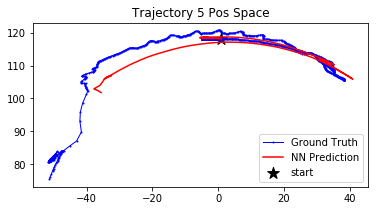

In [3]:
idx=4
md='sim_cont_trajT_bs512_model512_BS64_loadT_ho40'
file_name='/Users/zsbjltwjj/Desktop/robotic_hand_simulator/sim_data_cont_v0_d4_m1_episodes.obj'
with open(file_name, 'rb') as filehandler:
    memory = pickle.load(filehandler,encoding='latin')
gd=memory[idx][:,:4]
gd_next=memory[idx][:,-4:]
ac=memory[idx][:,4:6]
def normalize(data,x_std_arr,x_mean_arr):
    return (data - x_mean_arr[:data.shape[-1]]) / x_std_arr[:data.shape[-1]]
def denormalize(data,y_std_arr,y_mean_arr):
    return data * y_std_arr[:data.shape[-1]] + y_mean_arr[:data.shape[-1]]
def get_ground_truth(gd,gd_next):
    traj=[gd[0,:2]]
    for i in range(gd.shape[0]-1):
        if (gd_next[i,:]==gd[i+1,:]).all():
            traj.append(gd[i+1,:2])
        else:
            traj.append(gd_next[i,:2])
            traj.append(gd[i+1,:2])
    traj.append(gd_next[-1,:2])
    return np.array(traj)
gd_truth=get_ground_truth(gd,gd_next)
model_name = path+md+'.pkl'
norm_name = path+'normalization_arr_'+md+'_py2'
with open(model_name, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')

def predict(init_state,ac,norm_name,model):
    with open(norm_name, 'rb') as pickle_file:
        x_norm_arr, y_norm_arr = pickle.load(pickle_file)
        x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
        y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]
    next_state_ls=[init_state[:2]]
    for i in range(ac.shape[0]):
        sa=np.concatenate([init_state,ac[i,:]])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= (sa[:4] + state_delta)
        next_state_ls.append(next_state[:2])
        init_state=next_state
    return np.array(next_state_ls)

pred_states=predict(gd[0,:],ac,norm_name,model)
print(pred_states.shape)
fig = plt.figure()
plt.scatter(gd_truth[0, 0], gd_truth[0, 1], s=150, c='k', marker="*",label='start')
plt.plot(gd_truth[:, 0], gd_truth[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
plt.plot(pred_states[:, 0], pred_states[:, 1], color='red', label='NN Prediction')
plt.axis('scaled')
plt.title('Trajectory '+str(idx+1)+ ' Pos Space')
plt.legend()
plt.show()
#fig_loc=pred_fig_path +'_traj_'+str(i+1)+'_pos.png'
fig.set_size_inches(10, 10)
#fig.savefig(fig_loc)


In [18]:
path='/Users/zsbjltwjj/Desktop/robotic_hand_simulator/'
pathnorm='/Users/zsbjltwjj/Desktop/beliefspaceplanning/'
filename=path+“”
with open(filename, 'rb') as filehandler:
    memory = pickle.load(filehandler,encoding='latin')
print(len(memory))
print(memory[0].shape)
sm=0
ct=0
for i in memory:
    #if i.shape[0]!=1:
    #print(i.shape[0])
        #for ln in range(i.shape[0]):
        #    if np.linalg.norm(i[ln,:4]-i[ln,-4:])>=3:
        #        print("a")
        #        break
    #if ct<647:
    if ct<100:
        print(i[0,:4])
    sm+=i.shape[0]
    ct+=1
    

array([1., 1., 1., 1.])